# MNIST Classification with CNN

# Install the required packages

In [2]:
!pip install torch==2.2.0 torchvision==0.17.0 matplotlib==3.7.4

## Loading and Preprocessing the Data

In [3]:
import torchvision
from torchvision import transforms

img_path = './'

transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(
    root=img_path, train=True, transform=transform, download=True)

In [4]:
from torch.utils.data import Subset
import torch

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(
    mnist_dataset, torch.arange(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(root=img_path, train=False, transform=transform, download=True)


In [5]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

## Constructing the Model

In [6]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(
    in_channels=1, out_channels=32, kernel_size=5, padding=2))

model.add_module('relu1', nn.ReLU())

model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))

model.add_module('relu2', nn.ReLU())

model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

model.add_module('flatten', nn.Flatten())

model.add_module('fc1', nn.Linear(3136, 1024))

model.add_module('relu3', nn.ReLU())

model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train(mode, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)

            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}'
              )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

## Training the Model

In [18]:
torch.manual_seed(1)

num_epochs = 20

In [19]:
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9972 val_accuracy: 0.9857
Epoch 2 accuracy: 0.9955 val_accuracy: 0.9891
Epoch 3 accuracy: 0.9932 val_accuracy: 0.9902
Epoch 4 accuracy: 0.9945 val_accuracy: 0.9922
Epoch 5 accuracy: 0.9965 val_accuracy: 0.9901
Epoch 6 accuracy: 0.9961 val_accuracy: 0.9892
Epoch 7 accuracy: 0.9964 val_accuracy: 0.9904
Epoch 8 accuracy: 0.9973 val_accuracy: 0.9921
Epoch 9 accuracy: 0.9980 val_accuracy: 0.9913
Epoch 10 accuracy: 0.9974 val_accuracy: 0.9912
Epoch 11 accuracy: 0.9981 val_accuracy: 0.9887
Epoch 12 accuracy: 0.9974 val_accuracy: 0.9918
Epoch 13 accuracy: 0.9980 val_accuracy: 0.9903
Epoch 14 accuracy: 0.9983 val_accuracy: 0.9908
Epoch 15 accuracy: 0.9982 val_accuracy: 0.9905
Epoch 16 accuracy: 0.9987 val_accuracy: 0.9911
Epoch 17 accuracy: 0.9986 val_accuracy: 0.9907
Epoch 18 accuracy: 0.9986 val_accuracy: 0.9903
Epoch 19 accuracy: 0.9985 val_accuracy: 0.9916
Epoch 20 accuracy: 0.9982 val_accuracy: 0.9893


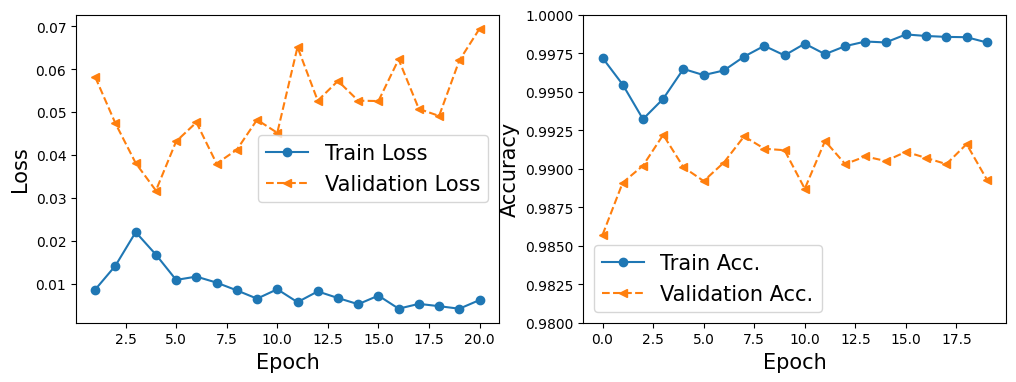

In [25]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train Loss')
ax.plot(x_arr, hist[1], '--<', label='Validation Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist[2], '-o', label='Train Acc.')
ax.plot(hist[3], '--<', label='Validation Acc.')
ax.legend(fontsize=15)
ax.set_ylim(0.98, 1)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()


## Evaluating the Model

In [27]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)

is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()

print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9918


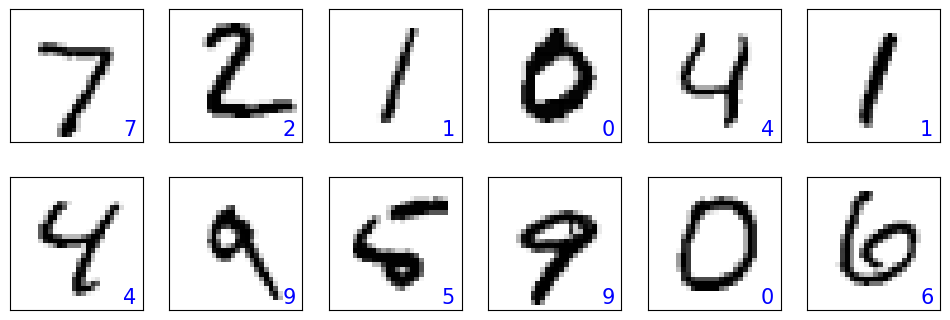

In [29]:
fig = plt.figure(figsize=(12, 4))

for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])

    img = mnist_test_dataset[i][0][0, :, :]

    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)

    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()